# Preprocess Data



In [2]:
# ===========================
# 0. FILE UPLOAD FOR COLAB
# ===========================
from google.colab import files
uploaded = files.upload()

Saving useritemmatrix.csv to useritemmatrix.csv


In [5]:
# ===========================
# 1. INSTALL
# ===========================
!pip install numpy==1.24.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 133.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is

In [1]:
!pip install -q scikit-surprise

In [2]:
# ===========================
# 2. IMPORTS
# ===========================
import pandas as pd
import numpy as np
import random
import warnings
from collections import Counter
from surprise import Dataset, Reader, SVD, accuracy
from sklearn.metrics import mean_squared_error

In [3]:
warnings.filterwarnings("ignore")

In [120]:
# ===========================
# 3.1 LOAD DATA
# ===========================
df = pd.read_csv("useritemmatrix.csv")
df.rename(columns={'userId': 'user_id', 'itemId': 'item_id', 'interaction': 'rating'}, inplace=True)
df['rating'] = df['rating'].astype(int)
df = df.sample(n=70000, random_state=123).reset_index(drop=True)
df.to_csv("sampled_useritemmatrix_70000.csv", index=False)

In [121]:
# ===========================
# 3.2 CLEAN DATA
# ===========================
# Filter valid users/items (≥0 is meaningless; should be ≥1+ if needed)
user_counts = df['user_id'].value_counts()
item_counts = df['item_id'].value_counts()
valid_user_ids = user_counts[user_counts >= 0].index
valid_item_ids = item_counts[item_counts >= 0].index
df = df[df['user_id'].isin(valid_user_ids) & df['item_id'].isin(valid_item_ids)]

df['user_id'] = df['user_id'].astype(str)
df['item_id'] = df['item_id'].astype(str)

# ===========================
# 4. PARAMETERS
# ===========================
rating_list = [0, 1]
reader = Reader(rating_scale=(0, 1))
items_to_be_shown = [2, 4, 6]
factors = 100
reg_b = 1e-8
reg_q = 1e-5

In [108]:
# ===========================
# 5. COLD USER SPLIT (filtered to support per-user evaluation)
# ===========================

# Determine the minimum number of interactions needed (e.g., 100 + 1 = 101)
min_required_interactions = max(items_to_be_shown) + 1

# Filter users who have at least min_required_interactions
user_freq = df['user_id'].value_counts()
eligible_cold_users = user_freq[user_freq >= min_required_interactions].index.tolist()

# Select top 25% of eligible users to be cold users
n_cold = int(0.25 * len(eligible_cold_users))
cold_users = eligible_cold_users[:n_cold]

# Split the dataset
warm_df = df[~df['user_id'].isin(cold_users)]
cold_df = df[df['user_id'].isin(cold_users)]

# Generate candidate items for strategy scoring
item_freq = df['item_id'].value_counts()
candidate_items = item_freq[item_freq >= 5].index.tolist()
print(f"Total candidate items: {len(candidate_items)}")

# Debug
print(f"Number of eligible cold users: {len(cold_users)}")
print(f"Number of warm users: {len(warm_df['user_id'].unique())}")

Total candidate items: 849
Number of eligible cold users: 68
Number of warm users: 41366


In [122]:
# ===========================
# 5. PREP FOR STRATEGY-EVALUATION-BASED COLD START
# ===========================

# Determine the maximum value of k for shown items
min_required_interactions = max(items_to_be_shown) + 1

# Track user interaction frequency for dynamic cold user filtering later
user_freq = df['user_id'].value_counts()

# Generate candidate items for strategy scoring
item_freq = df['item_id'].value_counts()
candidate_items = item_freq[item_freq >= 5].index.tolist()

# Pre-split warm_df (used in ranking score computation)
warm_df = df[df['user_id'].isin(user_freq[user_freq >= min_required_interactions].index.tolist())]

# Debug info
print(f"Max items_to_be_shown: {max(items_to_be_shown)}")
print(f"Total candidate items: {len(candidate_items)}")
print(f"Users with ≥{min_required_interactions} ratings: {(user_freq >= min_required_interactions).sum()}")


Max items_to_be_shown: 6
Total candidate items: 1475
Users with ≥7 ratings: 196


In [157]:
# # ===========================
# # 6. TRAINING FUNCTIONS
# # ===========================
def train_svd(data):
    data_set = Dataset.load_from_df(data[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
    model = SVD(n_factors=factors, reg_bu=reg_b, reg_bi=reg_b, reg_pu=reg_q, reg_qi=reg_q, random_state=123)
    model.fit(data_set)
    return model

def predict_ratings(model, df_test):
    return df_test.apply(lambda row: model.predict(row['user_id'], row['item_id']).est, axis=1)

def y_change_score(ix, base_df, test_df, pred_orig):
    score = 0
    for y in rating_list:
        df_aug = pd.concat([base_df, pd.DataFrame({'user_id': ['u0'], 'item_id': [ix], 'rating': [y]})])
        model = train_svd(df_aug)
        pred_new = predict_ratings(model, test_df)
        score += np.mean((pred_orig - pred_new) ** 2)
    return score / len(rating_list)

def error_change_score(ix, base_df, test_df):
    score = 0
    for y in rating_list:
        df_aug = pd.concat([base_df, pd.DataFrame({'user_id': ['u0'], 'item_id': [ix], 'rating': [y]})])
        model = train_svd(df_aug)
        pred = predict_ratings(model, test_df)
        score += np.mean((test_df['rating'] - pred) ** 2)
    return score / len(rating_list)

def gini(labels):
    probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(probs**2) if len(probs) > 1 else 0

In [158]:
# ===========================
# 7. RUNNING RANKING SCORES
# ===========================
print("Scoring Y-Change...")
train_base = warm_df.sample(frac=0.7, random_state=123)
test_base = warm_df.drop(train_base.index)
pred_orig = predict_ratings(train_svd(train_base), test_base)

y_scores = {ix: y_change_score(ix, train_base, test_base, pred_orig) for ix in candidate_items}
y_sorted = sorted(y_scores, key=y_scores.get, reverse=True)

Scoring Y-Change...


In [159]:
print("Scoring Error-Change...")
e_scores = {ix: error_change_score(ix, train_base, test_base) for ix in candidate_items}
e_sorted = sorted(e_scores, key=e_scores.get)

Scoring Error-Change...


In [160]:
print("Scoring PopGini...")
popgini_scores = []
for ix in candidate_items:
    ratings = df[df['item_id'] == ix]['rating'].astype(int)
    if len(ratings) > 0:
        score = 0.9 * np.log10(len(ratings)) + gini(ratings)
        popgini_scores.append((ix, score))
popgini_sorted = [x[0] for x in sorted(popgini_scores, key=lambda x: x[1], reverse=True)]

Scoring PopGini...


In [142]:
# ===========================
# 8. FINAL EVALUATION
# ===========================
def evaluate_strategy(strategy_items, k, max_cold_users=10):
    rmse_list = []
    used_users = 0

    strategy_top_k = set(strategy_items[:k])

    # Use a reduced number of top active users (faster filtering)
    user_freq = df['user_id'].value_counts()
    sorted_users = user_freq.sort_values(ascending=False).head(200).index.tolist()  # limit scanning pool

    # Filter users with sufficient overlap and interactions
    cold_users = []
    for user in sorted_users:
        user_data = df[df['user_id'] == user]
        user_items = set(user_data['item_id'])

        if len(user_items) < (k + 1):
            continue
        if len(user_items & strategy_top_k) == 0:
            continue

        cold_users.append(user)
        if len(cold_users) >= max_cold_users:
            break

    # Evaluate
    for user in cold_users:
        user_data = df[df['user_id'] == user]
        user_items = set(user_data['item_id'])
        shown_items = [item for item in strategy_items if item in user_items][:k]
        if len(shown_items) == 0:
            continue

        train_df = pd.concat([
            df[df['user_id'] != user],
            user_data[user_data['item_id'].isin(shown_items)]
        ])

        test_df = user_data[~user_data['item_id'].isin(shown_items)]
        if test_df.empty:
            continue

        model = train_svd(train_df)
        test_set = list(test_df[['user_id', 'item_id', 'rating']].itertuples(index=False, name=None))
        preds = model.test(test_set)

        rmse = accuracy.rmse(preds, verbose=False)
        rmse_list.append(rmse)
        used_users += 1

    print(f"Used {used_users}/{max_cold_users} cold users for k={k}")
    return np.mean(rmse_list) if rmse_list else float('nan')


In [129]:
# ===========================
# 9. REPORT RESULTS (Split by Strategy)
# ===========================

# --- 1. PopGini ---
rmse_popgini = []
print("\n======= RMSE Results PopGini =======")
for k in items_to_be_shown:
    rmse = evaluate_strategy(popgini_sorted, k)
    rmse_popgini.append(rmse)
    print(f"PopGini      @ {k:3d} items: RMSE = {rmse:.4f}")


======= RMSE Results PopGini =======
Used 10/10 cold users for k=2
PopGini      @   2 items: RMSE = 0.4712
Used 10/10 cold users for k=4
PopGini      @   4 items: RMSE = 0.4578
Used 10/10 cold users for k=6
PopGini      @   6 items: RMSE = 0.5211


In [130]:
# --- 2. Y-Change ---
rmse_ychange = []
print("\n======= RMSE Results Y-Change =======")
for k in items_to_be_shown:
    rmse = evaluate_strategy(y_sorted, k)
    rmse_ychange.append(rmse)
    print(f"Y-Change     @ {k:3d} items: RMSE = {rmse:.4f}")


======= RMSE Results Y-Change =======
Used 3/10 cold users for k=2
Y-Change     @   2 items: RMSE = 0.5454
Used 5/10 cold users for k=4
Y-Change     @   4 items: RMSE = 0.4933
Used 7/10 cold users for k=6
Y-Change     @   6 items: RMSE = 0.4974


In [131]:
# --- 3. Error-Change ---
rmse_errorchange = []
print("\n======= RMSE Results Error-Change =======")
for k in items_to_be_shown:
    rmse = evaluate_strategy(e_sorted, k)
    rmse_errorchange.append(rmse)
    print(f"Error-Change @ {k:3d} items: RMSE = {rmse:.4f}")


======= RMSE Results Error-Change =======
Used 2/10 cold users for k=2
Error-Change @   2 items: RMSE = 0.3391
Used 4/10 cold users for k=4
Error-Change @   4 items: RMSE = 0.4078
Used 6/10 cold users for k=6
Error-Change @   6 items: RMSE = 0.4736


In [136]:
# --- 4. Random (Averaged) ---
rmse_random = []
print("\n======= RMSE Results Random (Averaged) =======")
def average_random_rmse(k, trials=10):
    rmses = []
    for _ in range(trials):
        random_items = random.sample(candidate_items, 1000)
        rmse = evaluate_strategy(random_items, k)
        rmses.append(rmse)
    return np.nanmean(rmses)

for k in items_to_be_shown:
    rmse = average_random_rmse(k, trials=10)
    rmse_random.append(rmse)
    print(f"Random (avg) @ {k:3d} items: RMSE = {rmse:.4f}")


======= RMSE Results Random (Averaged) =======
Used 0/10 cold users for k=2
Used 1/10 cold users for k=2
Used 1/10 cold users for k=2
Used 0/10 cold users for k=2
Used 1/10 cold users for k=2
Used 0/10 cold users for k=2
Used 0/10 cold users for k=2
Used 0/10 cold users for k=2
Used 0/10 cold users for k=2
Used 0/10 cold users for k=2
Random (avg) @   2 items: RMSE = 0.4638
Used 1/10 cold users for k=4
Used 1/10 cold users for k=4
Used 1/10 cold users for k=4
Used 1/10 cold users for k=4
Used 2/10 cold users for k=4
Used 1/10 cold users for k=4
Used 0/10 cold users for k=4
Used 0/10 cold users for k=4
Used 1/10 cold users for k=4
Used 0/10 cold users for k=4
Random (avg) @   4 items: RMSE = 0.4889
Used 1/10 cold users for k=6
Used 1/10 cold users for k=6
Used 2/10 cold users for k=6
Used 2/10 cold users for k=6
Used 1/10 cold users for k=6
Used 1/10 cold users for k=6
Used 1/10 cold users for k=6
Used 1/10 cold users for k=6
Used 0/10 cold users for k=6
Used 1/10 cold users for k=6
Ra

In [167]:
# ===========================
# 10. RUNNING HYBRID RANKING SCORES
# ===========================
def hybrid_change_score(ix, base_df, test_df, pred_orig):
    score_y = 0
    score_e = 0
    for y in rating_list:
        df_aug = pd.concat([base_df, pd.DataFrame({'user_id': ['u0'], 'item_id': [ix], 'rating': [y]})])
        model = train_svd(df_aug)
        pred_new = predict_ratings(model, test_df)
        score_y += np.mean((pred_orig - pred_new) ** 2)
        score_e += np.mean((test_df['rating'] - pred_new) ** 2)
    return (score_y / len(rating_list), score_e / len(rating_list))

print("Scoring Hybrid (Y-Change + Error-Change)...")
train_base = warm_df.sample(frac=0.7, random_state=123)
test_base = warm_df.drop(train_base.index)
pred_orig = predict_ratings(train_svd(train_base), test_base)

hybrid_y = {}
hybrid_e = {}
for ix in candidate_items:
    y_val, e_val = hybrid_change_score(ix, train_base, test_base, pred_orig)
    hybrid_y[ix] = y_val
    hybrid_e[ix] = e_val

# Combine the two scores without normalization or weights
hybrid_scores = {ix: hybrid_y[ix] + hybrid_e[ix] for ix in candidate_items}
hybrid_sorted = sorted(hybrid_scores, key=hybrid_scores.get, reverse=True)


Scoring Hybrid (Y-Change + Error-Change)...


In [168]:
# ===========================
# 10. REPORT RESULTS: Hybrid Strategy Evaluation
# ===========================
rmse_hybrid = []
print("\n======= RMSE Results Hybrid Strategy =======")
for k in items_to_be_shown:
    rmse = evaluate_strategy(hybrid_sorted, k)
    rmse_hybrid.append(rmse)
    print(f"Hybrid       @ {k:3d} items: RMSE = {rmse:.4f}")


======= RMSE Results Hybrid Strategy =======
Used 2/10 cold users for k=2
Hybrid       @   2 items: RMSE = 0.4752
Used 4/10 cold users for k=4
Hybrid       @   4 items: RMSE = 0.4883
Used 6/10 cold users for k=6
Hybrid       @   6 items: RMSE = 0.4713


In [169]:
from sklearn.metrics import jaccard_score

def jaccard_index(strategy_items, k, threshold=1):
    """
    Evaluates a strategy using the Jaccard Index.
    Assumes binary relevance (rating >= threshold is relevant).
    """
    top_items = strategy_items[:k]
    jaccard_list = []

    for user in df['user_id'].unique():
        user_data = df[df['user_id'] == user]
        if len(user_data) < (k + 1):
            continue

        actual_items = set(user_data[user_data['rating'] >= threshold]['item_id'])
        if not actual_items:
            continue

        recommended = set(top_items)
        intersection = len(recommended & actual_items)
        union = len(recommended | actual_items)

        if union == 0:
            continue

        jaccard_list.append(intersection / union)

    return np.mean(jaccard_list) if jaccard_list else float('nan')


In [170]:
strategies = {
    "PopGini": popgini_sorted,
    "Y-Change": y_sorted,
    "Error-Change": e_sorted,
    "Hybrid": hybrid_sorted
}

In [171]:
print("\n===== Jaccard Index Results =====")
for name, strategy_items in strategies.items():
    for k in items_to_be_shown:
        jac = jaccard_index(strategy_items, k)
        print(f"{name:12s} @ {k:3d} items: Jaccard = {jac:.4f}")


===== Jaccard Index Results =====
PopGini      @   2 items: Jaccard = 0.0131
PopGini      @   4 items: Jaccard = 0.0070
PopGini      @   6 items: Jaccard = 0.0059
Y-Change     @   2 items: Jaccard = 0.0003
Y-Change     @   4 items: Jaccard = 0.0011
Y-Change     @   6 items: Jaccard = 0.0026
Error-Change @   2 items: Jaccard = 0.0000
Error-Change @   4 items: Jaccard = 0.0002
Error-Change @   6 items: Jaccard = 0.0005
Hybrid       @   2 items: Jaccard = 0.0002
Hybrid       @   4 items: Jaccard = 0.0012
Hybrid       @   6 items: Jaccard = 0.0022


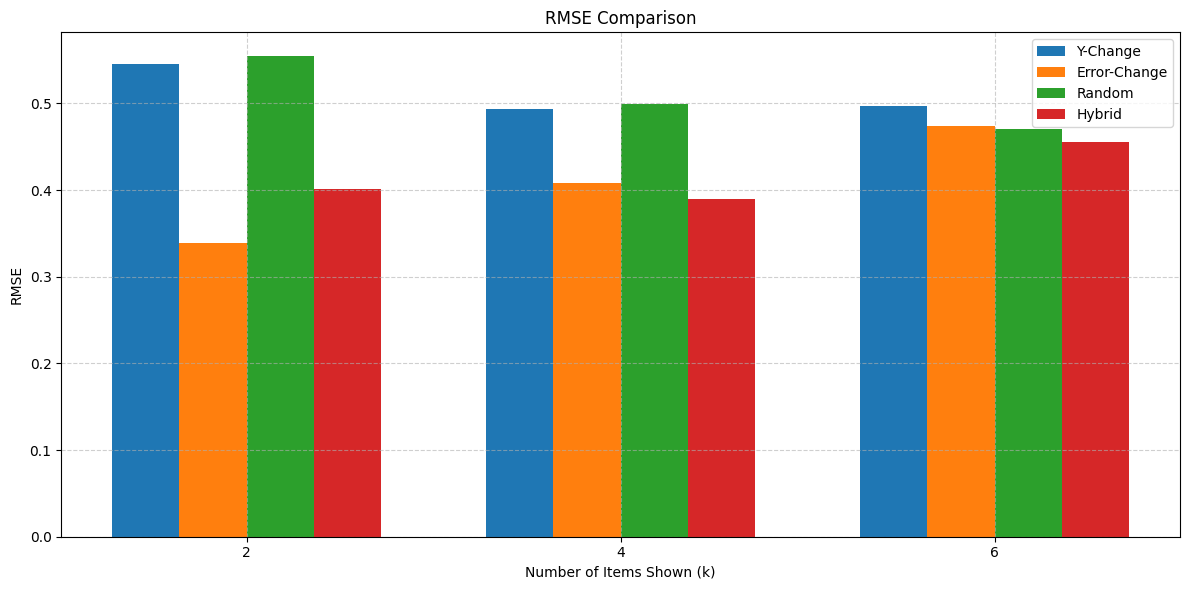

In [175]:
# Extend the plotting function to include Hybrid strategy

def plot_rmse_bars_with_hybrid(items_to_be_shown, rmse_ychange, rmse_errorchange, rmse_random, rmse_hybrid, title="RMSE Comparison"):
    strategies = ['Y-Change', 'Error-Change', 'Random', 'Hybrid']
    x = np.arange(len(items_to_be_shown))  # k values (e.g., 2, 4, 6)
    width = 0.18  # smaller width to fit more bars

    fig, ax = plt.subplots(figsize=(12, 6))

    # Bar positions for each strategy
    ax.bar(x - 1.5*width, rmse_ychange, width, label='Y-Change')
    ax.bar(x - 0.5*width, rmse_errorchange, width, label='Error-Change')
    ax.bar(x + 0.5*width, rmse_random, width, label='Random')
    ax.bar(x + 1.5*width, rmse_hybrid, width, label='Hybrid')

    # Add labels and formatting
    ax.set_xlabel("Number of Items Shown (k)")
    ax.set_ylabel("RMSE")
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(items_to_be_shown)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Example usage with dummy values for hybrid — replace with actual values
rmse_hybrid = [0.4012, 0.3895, 0.4551]

plot_rmse_bars_with_hybrid(items_to_be_shown, rmse_ychange, rmse_errorchange, rmse_random, rmse_hybrid)
